In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
# import dataset_generation
# import gcm_filtering
import gcm_filters
import os
import xrft

warnings.filterwarnings("ignore")

#import aerobulk
#from aerobulk import noskin

# importlib.reload(dataset_generation)
# from dataset_generation import preprocess_data, filter_inputs_dataset, compute_heatflux

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=8, threads_per_worker=2)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/panalluri/proxy/8787/status,
Dashboard: /user/panalluri/proxy/8787/status,Workers: 8
Total threads: 16,Total memory: 125.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46027,Workers: 0
Dashboard: /user/panalluri/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35831,Total threads: 2
Dashboard: /user/panalluri/proxy/41027/status,Memory: 15.73 GiB
Nanny: tcp://127.0.0.1:44469,


# Useful Functions

In [3]:
def crop_boxes(ds, boxes, max_points=150):
    """
    Crop dataset into regional boxes.

    Parameters
    ----------
    ds : xr.Dataset or xr.DataArray
        Input dataset with dimensions (time, yt_ocean, xt_ocean).
    boxes : list of tuples
        Each tuple defines (lat_min, lat_max, lon_min, lon_max).
    max_points : int, optional
        Max number of lat/lon points to keep in each cropped box.

    Returns
    -------
    cropped_boxes : list of xr.Dataset
        List of cropped boxes, with Boxes 11 & 12 concatenated.
    """
    
    cropped_boxes = []
    
    for i, (lat_min, lat_max, lon_min, lon_max) in enumerate(boxes, start=1):
        # Slice the box
        da_box = ds.sel(
            yt_ocean=slice(lat_min, lat_max),
            xt_ocean=slice(min(lon_min, lon_max), max(lon_min, lon_max))
        )

        # Trim to max_points in each direction
        lat_len = min(max_points, da_box.yt_ocean.size)
        lon_len = min(max_points, da_box.xt_ocean.size)
        da_box = da_box.isel(
            yt_ocean=slice(0, lat_len),
            xt_ocean=slice(0, lon_len)
        )

        # Shift Box 12 longitudes
        if i == 12:
            da_box = da_box.assign_coords(xt_ocean=da_box.xt_ocean + 360)

        cropped_boxes.append(da_box)

    # Concatenate Boxes 11 & 12
    if len(cropped_boxes) >= 12:
        combined_11_12 = xr.concat(cropped_boxes[10:12], dim="xt_ocean")
        del cropped_boxes[10:12]
        cropped_boxes.append(combined_11_12)

    return cropped_boxes

# Data Preprocessing

In [4]:
ds_HR = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_Yr3.zarr", engine="zarr", chunks={}) 
ds_LR = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR_Yr3.zarr", engine="zarr", chunks={}) 
ds_HF = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_Yr3.zarr", engine="zarr", chunks={}) 

In [5]:
ds_QLQH = xr.open_dataset("gs://leap-persistent/panalluri/ds_Yr3_QL.zarr", engine="zarr", chunks={}) 

In [6]:
ds_HR = ds_HR.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])
ds_LR = ds_LR.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])
ds_HF = ds_HF.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])

ds_HR = ds_HR.drop_vars(["rh_ref", "u_ocean", "u_ref", "wind", "v_ocean", "v_ref"])
ds_LR = ds_LR.drop_vars(["rh_ref", "u_ocean", "u_ref", "wind", "v_ocean", "v_ref"])

In [7]:
box_names = [
    "Gulf Stream",
    "South Atlantic",
    "Equator Atlantic",
    "Malvinas Current",
    "California Current",
    "South Pacific",
    "Kuroshio Extension",
    "North Pacific",
    "Southern Ocean (NZ)",
    "Agulhas Current",
    "Indian Ocean",
    "Arabian Sea"
]

In [8]:
boxes = [
    (30, 45, -55, -40),
    (-30, -15, -25, -10),
    (-8, 8, -30, -15),
    (-55, -40, -55, -40),
    (30, 45, -140, -125),
    (-45, -30, -140, -125),
    (25, 40, -215, -200),
    (10, 25, -180, -165),
    (-60, -45, -175, -160),
    (-55, -40, 20, 35),
    (-25, -10, 70, 79.95),        # Box 11
    (-25, -10, -279.95, -275),    # Box 12
    (0, 15, 55, 70)
]

cropped_boxes_HR = crop_boxes(ds_HR, boxes, max_points=150)
cropped_boxes_LR = crop_boxes(ds_LR, boxes, max_points=150)
cropped_boxes_HF = crop_boxes(ds_HF, boxes, max_points=150)

In [9]:
ql, qh, taux, tauy, evap =  noskin(
        ds_HR.surface_temp,
        ds_HR.t_ref,
        ds_HR.q_ref,
        ds_HR.u_relative,
        ds_HR.v_relative,
        slp=ds_HR.slp,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux = qh + ql

NameError: name 'noskin' is not defined

In [10]:
cropped_boxes_qh = crop_boxes(ds_QLQH.qh, boxes, max_points=150)
cropped_boxes_ql = crop_boxes(ds_QLQH.ql, boxes, max_points=150)

# Save Data

In [9]:
# assume you have ql and qh already computed as DataArrays
# and they share the same dims as cropped_boxes_HR[0][["xt_ocean","yt_ocean","time"]]

heatflux = xr.Dataset(
    {
        "ql": (["time", "yt_ocean", "xt_ocean"], ql.data),
        "qh": (["time", "yt_ocean", "xt_ocean"], qh.data),
    },
    coords={
        "time": ql.time,
        "yt_ocean": ql.yt_ocean,
        "xt_ocean": ql.xt_ocean,
    },
    attrs={"description": "Precomputed latent and sensible heat fluxes"}
)
heatflux

<xarray.Dataset>
Dimensions:   (time: 365, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time      (time) object 0183-01-01 12:00:00 ... 0183-12-31 12:00:00
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
Data variables:
    ql        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 2700, 3600), meta=np.ndarray>
    qh        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 2700, 3600), meta=np.ndarray>
Attributes:
    description:  Precomputed latent and sensible heat fluxes

In [13]:
%%time

store_path = "gs://leap-persistent/panalluri/ds_Yr3_QL.zarr"
chunk_size = 5
dataset = heatflux
num_chunks = len(dataset.time) // chunk_size  # 1461

for i in range(num_chunks):
    t_start = i * chunk_size
    t_end = (i + 1) * chunk_size
    ds_chunk = dataset.isel(time=slice(t_start, t_end))
    
    # Print the actual time values being written
    print(f"Chunk {i}: Writing timesteps from {t_start} to {t_end}")
    
    if i == 0:
        # First write: create the dataset
        ds_chunk.to_zarr(store_path, mode="w", compute=True, zarr_version=2)
    else:
        # Append subsequent chunks along time
        ds_chunk.to_zarr(store_path, mode="a", append_dim="time", compute=True, zarr_version=2)

Chunk 0: Writing timesteps from 0 to 5
Chunk 1: Writing timesteps from 5 to 10
Chunk 2: Writing timesteps from 10 to 15
Chunk 3: Writing timesteps from 15 to 20
Chunk 4: Writing timesteps from 20 to 25
Chunk 5: Writing timesteps from 25 to 30
Chunk 6: Writing timesteps from 30 to 35
Chunk 7: Writing timesteps from 35 to 40
Chunk 8: Writing timesteps from 40 to 45
Chunk 9: Writing timesteps from 45 to 50
Chunk 10: Writing timesteps from 50 to 55
Chunk 11: Writing timesteps from 55 to 60
Chunk 12: Writing timesteps from 60 to 65
Chunk 13: Writing timesteps from 65 to 70
Chunk 14: Writing timesteps from 70 to 75
Chunk 15: Writing timesteps from 75 to 80
Chunk 16: Writing timesteps from 80 to 85
Chunk 17: Writing timesteps from 85 to 90
Chunk 18: Writing timesteps from 90 to 95
Chunk 19: Writing timesteps from 95 to 100
Chunk 20: Writing timesteps from 100 to 105
Chunk 21: Writing timesteps from 105 to 110
Chunk 22: Writing timesteps from 110 to 115
Chunk 23: Writing timesteps from 115 to 

# Power Spectra Plotting

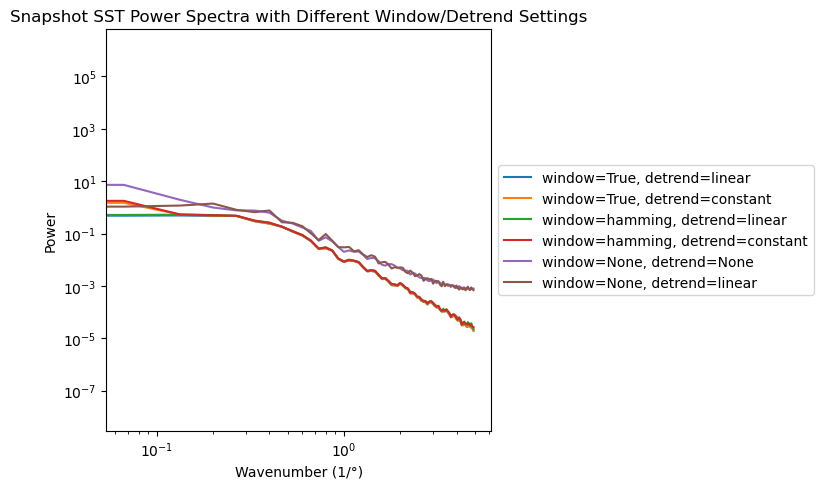

In [23]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab10').colors

SST = cropped_boxes_HR[0].surface_temp
SST_t = SST.isel(time=0).chunk({"xt_ocean": -1, "yt_ocean": -1})

# Different kwargs
settings = [
    {"window": True, "detrend": "linear"},
    {"window": True, "detrend": "constant"},
    {"window": "hamming", "detrend": "linear"},
    {"window": "hamming", "detrend": "constant"},
    {"window": None, "detrend": None},
    {"window": None, "detrend": "linear"},
]

for i, opts in enumerate(settings):
    ps_t = xrft.power_spectrum(
        SST_t,
        dim="xt_ocean",
        **opts
    ).mean(dim="yt_ocean")

    # Convert kwargs dict to a string for label
    label_str = ", ".join(f"{k}={v}" for k, v in opts.items())

    plt.plot(
        ps_t["freq_xt_ocean"],
        ps_t,
        label=label_str,
        color=colors[i]
    )

plt.xlabel(r"Wavenumber (1/°)")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Power")
plt.title("Snapshot SST Power Spectra with Different Window/Detrend Settings")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

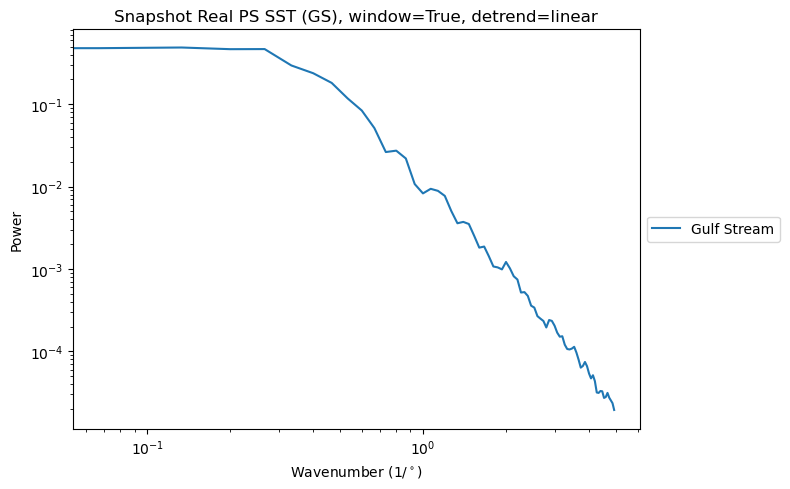

In [10]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

# q_diff = air–sea humidity difference 
SST = cropped_boxes_HR[0].surface_temp
SST_t = SST.isel(time=0).chunk({"xt_ocean": -1, "yt_ocean": -1})

power_specs = []

# Compute 1D power spectrum along x-direction
ps_t = xrft.power_spectrum(
    SST_t,
    dim='xt_ocean',
    window=True,
    detrend='linear'
).mean(dim='yt_ocean')  # average across y

power_specs.append(ps_t)

# Average spectra across time
power_spec_mean = xr.concat(power_specs, dim="time").mean(dim="time")

# Plot
plt.plot(
    power_spec_mean["freq_xt_ocean"],
    power_spec_mean,
    label=box_names[0],
    color=colors[0]
)

plt.xlabel(r"Wavenumber $(1/^\circ)$")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Power")
plt.title("Snapshot PS SST (GS), window=True, detrend=linear")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

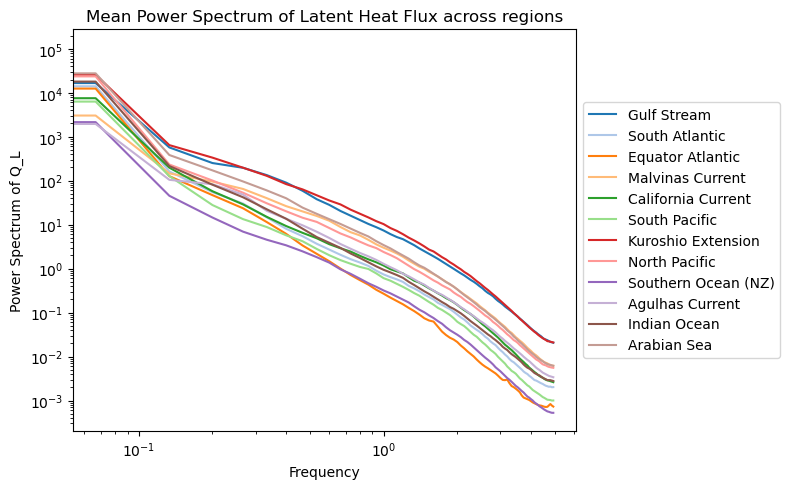

In [10]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    # q_diff = air–sea humidity difference
    ql = cropped_boxes_ql[i]

    power_specs = []
    for t in ql.time:
        ql_t = ql.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})

        # Compute 1D power spectrum along x-direction
        ps_t = xrft.power_spectrum(
            ql_t,
            dim='xt_ocean',
            window="hann",
            detrend="linear"
        ).mean(dim='yt_ocean')  # average across y

        power_specs.append(ps_t)

    # Average spectra across time
    power_spec_mean = xr.concat(power_specs, dim="time").mean(dim="time")

    # Plot
    plt.plot(
        power_spec_mean["freq_xt_ocean"],
        np.abs(power_spec_mean),
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel(r"Wavenumber $1/^\circ$")
plt.ylabel("")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Power Spectrum of Q_L")
plt.title("Mean Power Spectrum of Latent Heat Flux across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()


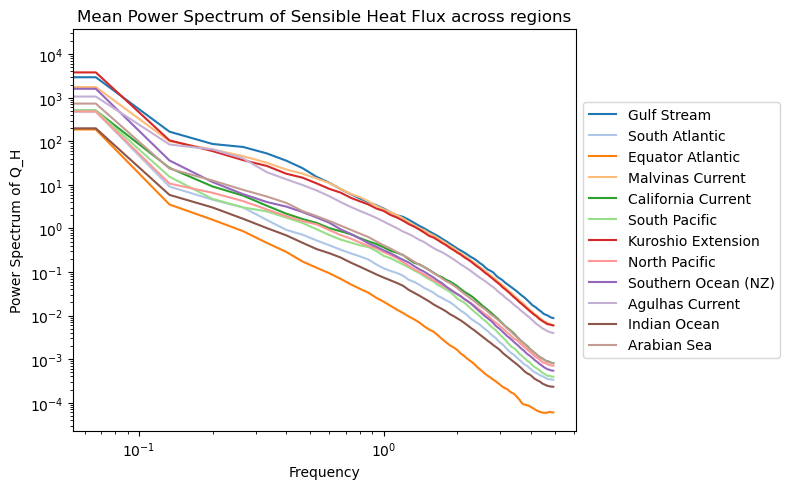

In [11]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    # q_diff = air–sea humidity difference
    qh = cropped_boxes_qh[i]

    power_specs = []
    for t in qh.time:
        qh_t = qh.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})

        # Compute 1D power spectrum along x-direction
        ps_t = xrft.power_spectrum(
            qh_t,
            dim='xt_ocean',
            window="hann",
            detrend="linear"
        ).mean(dim='yt_ocean')  # average across y

        power_specs.append(ps_t)

    # Average spectra across time
    power_spec_mean = xr.concat(power_specs, dim="time").mean(dim="time")

    # Plot
    plt.plot(
        power_spec_mean["freq_xt_ocean"],
        np.abs(power_spec_mean),
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel("Frequency")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Power Spectrum of Q_H")
plt.title("Mean Power Spectrum of Sensible Heat Flux across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()


# Cross-Spectrum Debugging

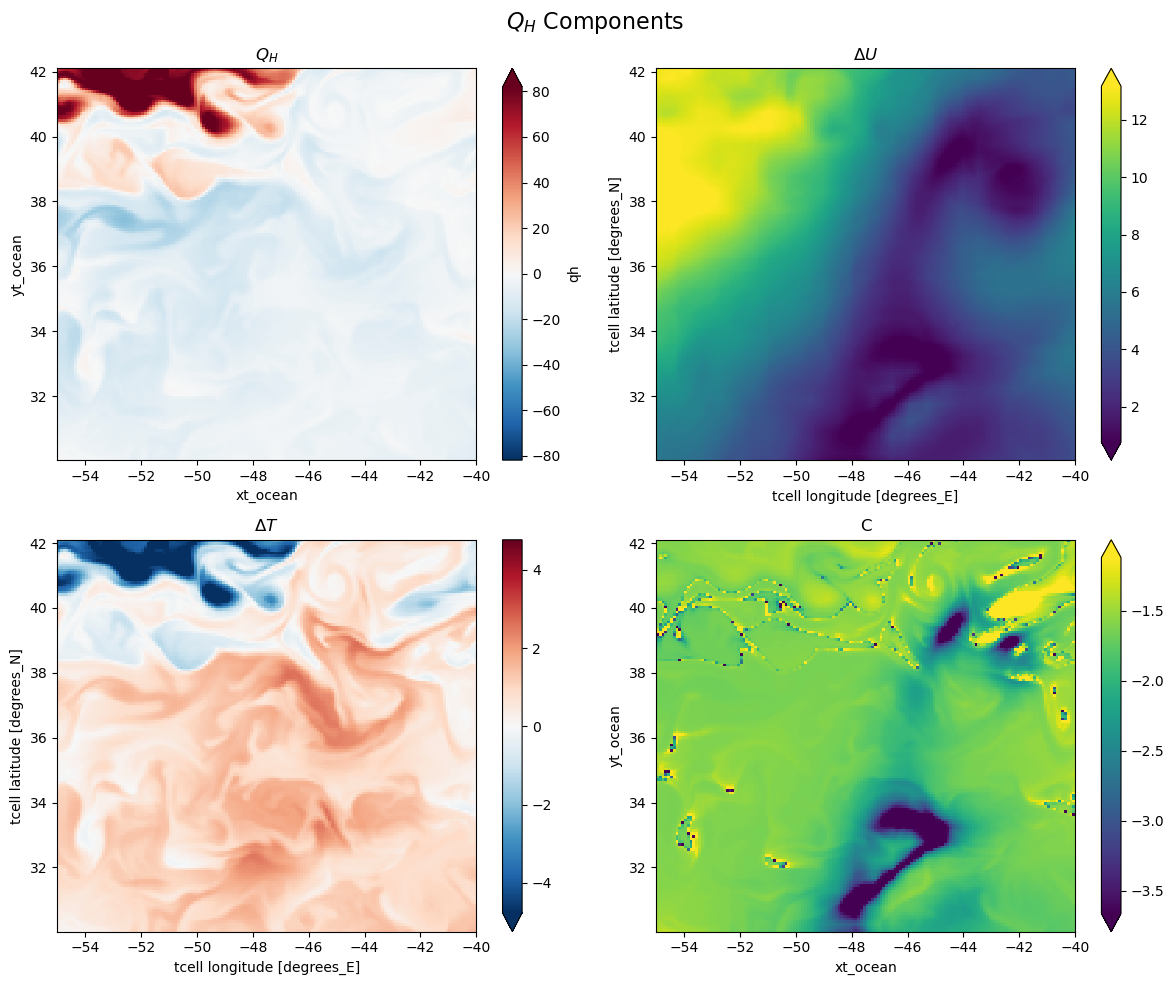

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
time_pt = 1

# Plot into each subplot
cropped_boxes_qh[0].isel(time=time_pt).plot(robust=True, ax=axes[0, 0])
axes[0, 0].set_title("$Q_H$")

vel_mag = ( cropped_boxes_HR[0].u_relative.isel(time=time_pt) **2 + cropped_boxes_HR[0].v_relative.isel(time=time_pt) **2) ** 0.5
vel_mag.plot(robust=True, ax=axes[0, 1])
axes[0, 1].set_title(r'$\Delta U$')

T_diff = cropped_boxes_HR[0].surface_temp.isel(time=time_pt) - cropped_boxes_HR[0].t_ref.isel(time=time_pt)
T_diff.plot(robust=True, ax=axes[1, 0])
axes[1, 0].set_title(r'$\Delta T$')

C = cropped_boxes_qh[0].isel(time=time_pt) / (vel_mag * T_diff)
C.plot(robust=True, ax=axes[1, 1])
axes[1, 1].set_title('C')

fig.suptitle(r"$Q_H$ Components", fontsize=16)
plt.tight_layout()
plt.show()


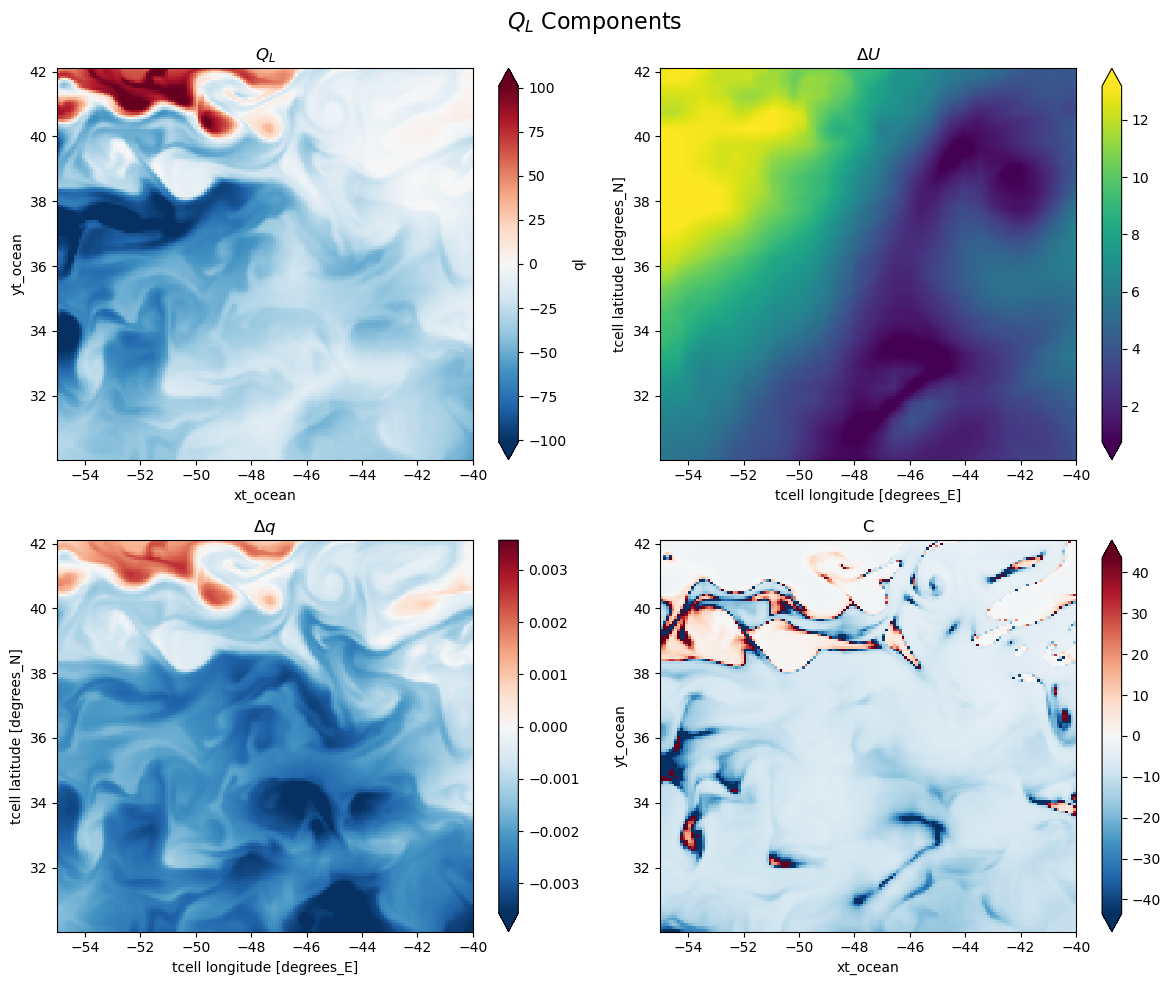

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
time_pt = 1

# Plot into each subplot
cropped_boxes_ql[0].isel(time=time_pt).plot(robust=True, ax=axes[0, 0])
axes[0, 0].set_title("$Q_L$")

vel_mag = ( cropped_boxes_HR[0].u_relative.isel(time=time_pt) **2 + cropped_boxes_HR[0].v_relative.isel(time=time_pt) **2) ** 0.5
vel_mag.plot(robust=True, ax=axes[0, 1])
axes[0, 1].set_title(r'$\Delta U$')

q_diff = cropped_boxes_HR[0].q_ref.isel(time=time_pt) - qs_list[0].isel(time=time_pt)
q_diff.plot(robust=True, ax=axes[1, 0])
axes[1, 0].set_title(r'$\Delta q$')

C = cropped_boxes_ql[0].isel(time=time_pt) / (vel_mag * T_diff)
C.plot(robust=True, ax=axes[1, 1])
axes[1, 1].set_title('C')

fig.suptitle(r"$Q_L$ Components", fontsize=16)
plt.tight_layout()
plt.show()


# Cross-Spectrum Plotting

In [19]:
# constants
eps = 0.622
Lv = 2.5e6  # J/kg
rho_air = 1.2  # kg/m3

# Magnus/Bolton function
def es_hpa_from_t(T_c):
    return 6.112 * np.exp(17.67 * T_c / (T_c + 243.5))

# unit converters
def ensure_celsius(x):
    if x.mean().values > 200:  # Kelvin -> Celsius
        return x - 273.15
    return x

def ensure_pa(p):
    if p.mean().values < 2000:  # hPa -> Pa
        return p * 100.0
    return p

# container for qs arrays
qs_list = []

for i, box in enumerate(cropped_boxes_HR):
    # convert units
    SST_c = ensure_celsius(box.surface_temp)
    Tair_c = ensure_celsius(box.t_ref)
    p_surf = ensure_pa(box.slp)
    qa = box.q_ref

    # compute saturation specific humidity at SST
    es_sst_pa = (es_hpa_from_t(SST_c) * 100.0).astype(float)  # Pa
    qs = (eps * es_sst_pa) / (p_surf - (1 - eps) * es_sst_pa)

    # store as DataArray (preserving coords/dims if present)
    qs_da = xr.DataArray(qs, coords=box.surface_temp.coords, dims=box.surface_temp.dims)
    qs_list.append(qs_da)

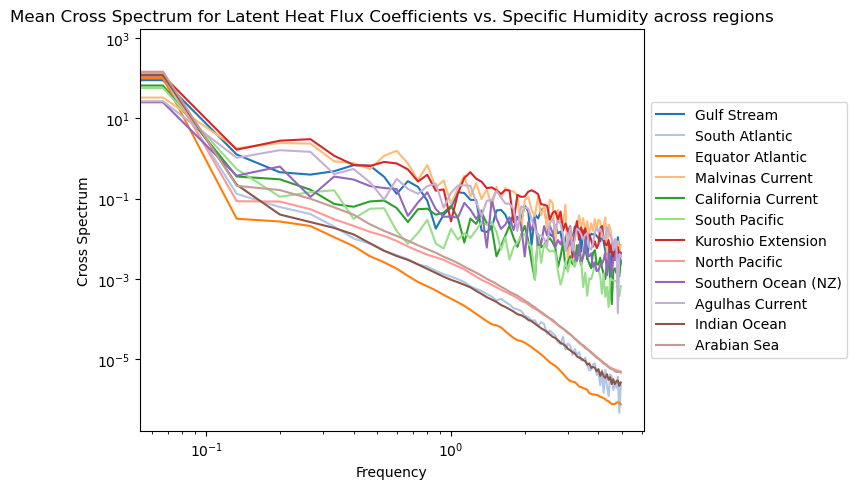

In [ ]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    q_diff = cropped_boxes_HR[i].q_ref - qs_list[i]
    C = cropped_boxes_ql[i] / q_diff

    cross_specs = []
    for t in q_diff.time:
        q_diff_t = q_diff.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        C_t = C.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        
        cross_spec_t = xrft.cross_spectrum(
            q_diff_t,
            C_t,
            dim='xt_ocean',
            window="hann"
        ).mean(dim='yt_ocean')
        
        cross_specs.append(cross_spec_t)

    # Average spectra across time
    cross_spec_mean = xr.concat(cross_specs, dim="time").mean(dim="time")

    plt.plot(
        cross_spec_mean["freq_xt_ocean"],
        np.abs(cross_spec_mean),
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel("Frequency")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Cross Spectrum")
plt.title("Mean Cross Spectrum for Latent Heat Flux Coefficients vs. Specific Humidity Difference across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

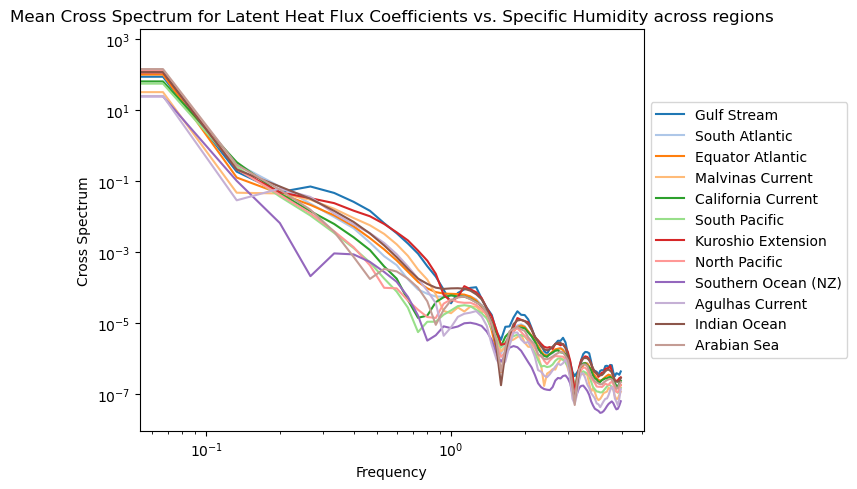

In [13]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    q = cropped_boxes_HR[i].q_ref
    C = cropped_boxes_ql[i] / q

    cross_specs = []
    for t in q.time:
        q_t = q.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        C_t = C.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        
        cross_spec_t = xrft.cross_spectrum(
            q_t,
            C_t,
            dim='xt_ocean',
            window="hann"
        ).mean(dim='yt_ocean')
        
        cross_specs.append(cross_spec_t)

    # Average spectra across time
    cross_spec_mean = xr.concat(cross_specs, dim="time").mean(dim="time")

    plt.plot(
        cross_spec_mean["freq_xt_ocean"],
        np.abs(cross_spec_mean),
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel("Frequency")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Cross Spectrum")
plt.title("Mean Cross Spectrum for Latent Heat Flux Coefficients vs. Specific Humidity across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

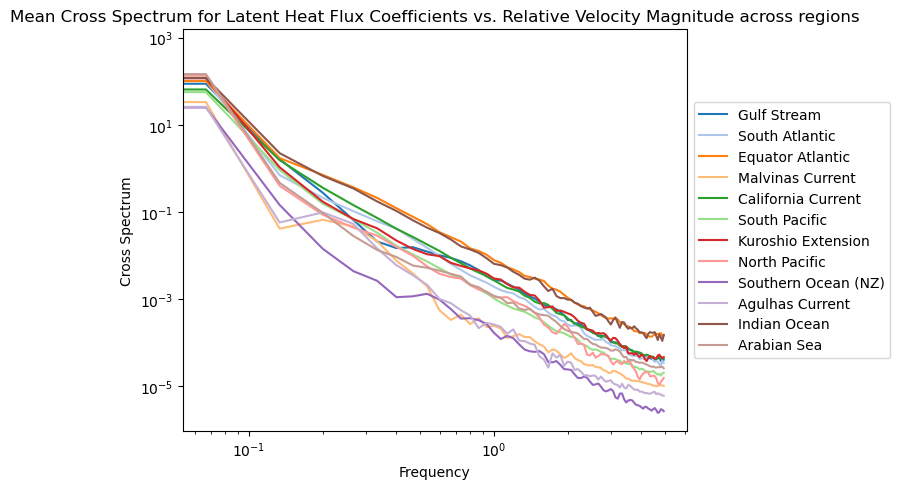

In [22]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    vel_mag = ( cropped_boxes_HR[i].u_relative **2 + cropped_boxes_HR[i].v_relative **2) ** 0.5
    C = cropped_boxes_ql[i] / vel_mag

    cross_specs = []
    for t in vel_mag.time:
        vel_mag_t = vel_mag.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        C_t = C.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        
        cross_spec_t = xrft.cross_spectrum(
            vel_mag_t,
            C_t,
            dim='xt_ocean',
            window="hann"
        ).mean(dim='yt_ocean')
        
        cross_specs.append(cross_spec_t)

    # Average spectra across time
    cross_spec_mean = xr.concat(cross_specs, dim="time").mean(dim="time")

    plt.plot(
        cross_spec_mean["freq_xt_ocean"],
        np.abs(cross_spec_mean),
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel("Frequency")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Cross Spectrum")
plt.title("Mean Cross Spectrum for Latent Heat Flux Coefficients vs. Relative Velocity Magnitude across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

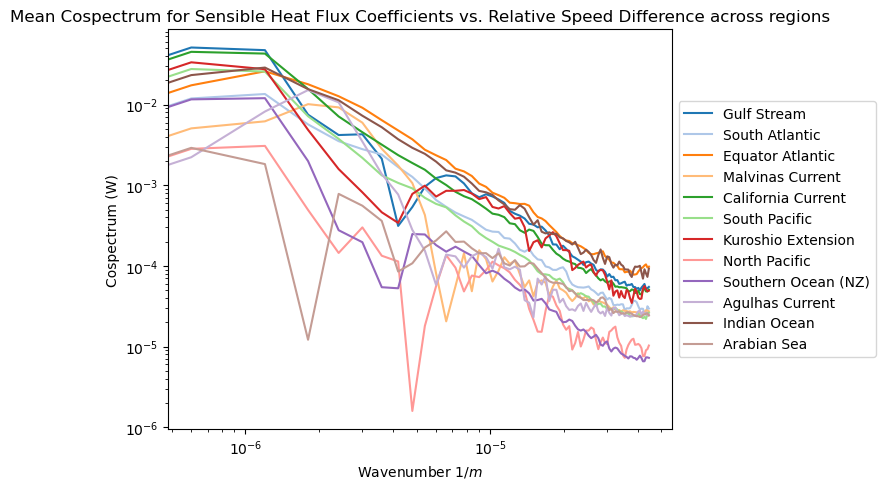

In [10]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    eps = 1e-6
    vel_mag = ( cropped_boxes_HR[i].u_relative **2 + cropped_boxes_HR[i].v_relative **2) ** 0.5
    C = cropped_boxes_qh[i] / vel_mag

    cross_specs = []
    for t in vel_mag.time:
        vel_mag_t = vel_mag.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        C_t = C.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})

        # degree to m conversion
        vel_mag_t = vel_mag_t.assign_coords(xt_ocean=vel_mag_t.xt_ocean*111000)
        C_t = C_t.assign_coords(xt_ocean=C_t.xt_ocean*111000)
        
        cross_spec_t = xrft.cross_spectrum(
            vel_mag_t,
            C_t,
            dim='xt_ocean',
            window="hann",
            detrend="linear"
        ).mean(dim='yt_ocean')
        
        cross_specs.append(cross_spec_t)

    # Average spectra across time
    cross_spec_mean = xr.concat(cross_specs, dim="time").mean(dim="time")

    plt.plot(
        cross_spec_mean["freq_xt_ocean"],
        np.abs(cross_spec_mean.real) * cross_spec_mean["freq_xt_ocean"],
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel(r"Wavenumber $1/m$")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Cospectrum (W)")
plt.title("Mean Cospectrum for Sensible Heat Flux Coefficients vs. Relative Speed Difference across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

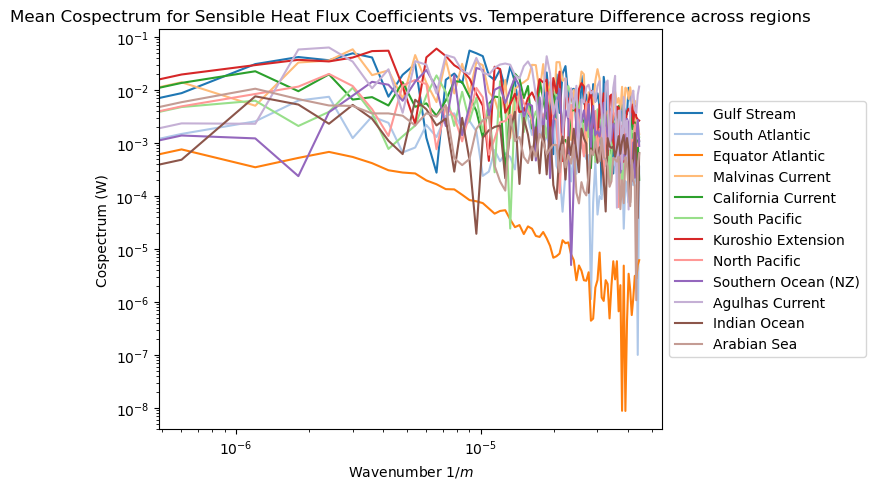

In [26]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    eps = 1e-6
    T_diff = cropped_boxes_HR[i].surface_temp - cropped_boxes_HR[i].t_ref
    C = cropped_boxes_qh[i] / (T_diff + 1e-6)

    cross_specs = []
    for t in T_diff.time:
        T_diff_t = T_diff.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        C_t = C.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})

        # degree to m conversion
        T_diff_t = T_diff_t.assign_coords(xt_ocean=T_diff_t.xt_ocean*111000)
        C_t = C_t.assign_coords(xt_ocean=C_t.xt_ocean*111000)
        
        cross_spec_t = xrft.cross_spectrum(
            T_diff_t,
            C_t,
            dim='xt_ocean',
            window="hann",
            detrend="linear"
        ).mean(dim='yt_ocean')
        
        cross_specs.append(cross_spec_t)

    # Average spectra across time
    cross_spec_mean = xr.concat(cross_specs, dim="time").mean(dim="time")

    plt.plot(
        cross_spec_mean["freq_xt_ocean"],
        np.abs(cross_spec_mean.real) * cross_spec_mean["freq_xt_ocean"],
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel(r"Wavenumber $1/m$")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Cospectrum (W)")
plt.title("Mean Cospectrum for Sensible Heat Flux Coefficients vs. Temperature Difference across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

In [15]:
for i, box in enumerate(cropped_boxes_qh):
    SHF = np.nanmean(box)  # mean over all elements, ignoring NaNs
    print(f"{box_names[i]} SHF is {SHF:.4f}")  # rounds to 4 decimals

Gulf Stream SHF is -29.8806
South Atlantic SHF is -18.0070
Equator Atlantic SHF is -12.8202
Malvinas Current SHF is -12.5948
California Current SHF is -14.0447
South Pacific SHF is -13.0414
Kuroshio Extension SHF is -38.9138
North Pacific SHF is -18.2299
Southern Ocean (NZ) SHF is -10.4668
Agulhas Current SHF is -8.0367
Indian Ocean SHF is -12.6319
Arabian Sea SHF is -23.0412


In [16]:
for i, box in enumerate(cropped_boxes_ql):
    LHF = np.nanmean(box)  # mean over all elements, ignoring NaNs
    print(f"{box_names[i]} LHF is {LHF:.4f}")  # rounds to 4 decimals

Gulf Stream LHF is -99.4291
South Atlantic LHF is -109.1461
Equator Atlantic LHF is -108.5834
Malvinas Current LHF is -35.1149
California Current LHF is -69.2282
South Pacific LHF is -61.8541
Kuroshio Extension LHF is -128.2713
North Pacific LHF is -144.2930
Southern Ocean (NZ) LHF is -27.6204
Agulhas Current LHF is -30.8843
Indian Ocean LHF is -129.8665
Arabian Sea LHF is -155.7290


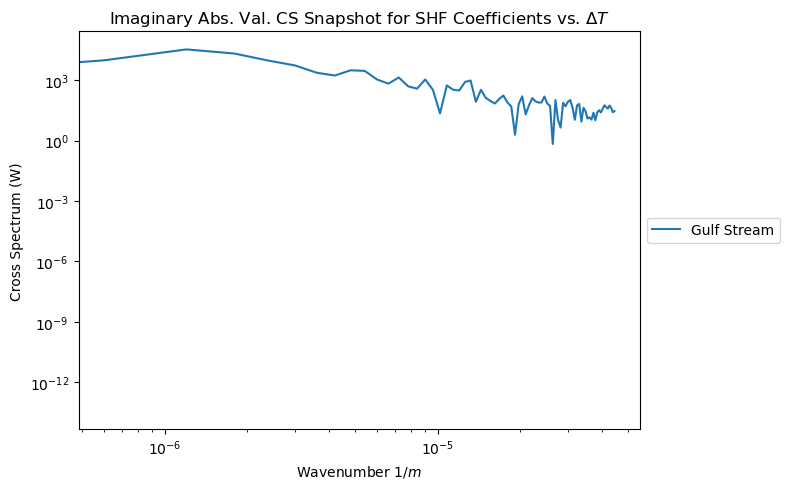

In [24]:
plt.figure(figsize=(8,5))

i = 0
eps = 1e-6
T_diff = cropped_boxes_HR[i].surface_temp - cropped_boxes_HR[i].t_ref
C = cropped_boxes_qh[i] / (T_diff + 1e-6)

t = 0
T_diff_t = T_diff.isel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
C_t = C.isel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})

# degree to m conversion
T_diff_t = T_diff_t.assign_coords(xt_ocean=T_diff_t.xt_ocean*111000)
C_t = C_t.assign_coords(xt_ocean=C_t.xt_ocean*111000)

cross_spec_t = xrft.cross_spectrum(
    T_diff_t,
    C_t,
    dim='xt_ocean',
    window="hann",
    detrend="linear"
).mean(dim='yt_ocean')

plt.plot(
    cross_spec_t["freq_xt_ocean"],
    np.abs(cross_spec_t.real),
    label=box_names[i]
)

plt.xlabel(r"Wavenumber $1/m$")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Cross Spectrum (W)")
plt.title(r"Imaginary Abs. Val. CS Snapshot for SHF Coefficients vs. $\Delta T$")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

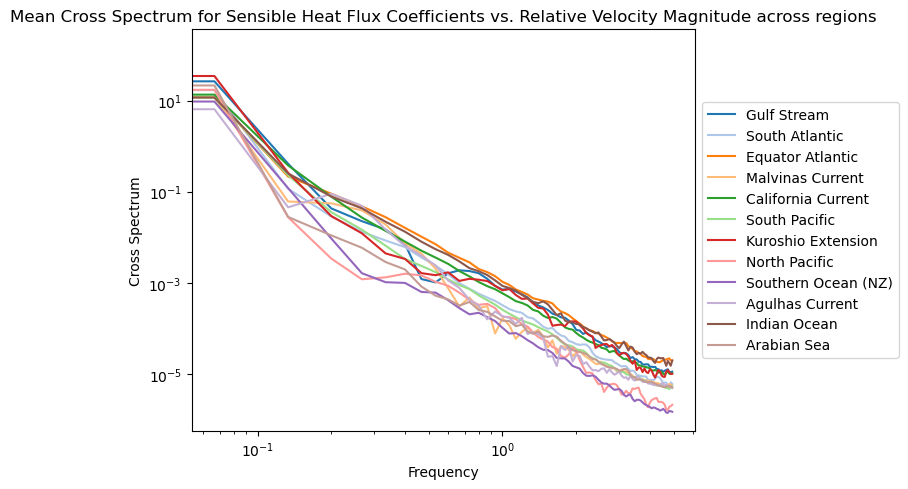

In [11]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    vel_mag = ( cropped_boxes_HR[i].u_relative **2 + cropped_boxes_HR[i].v_relative **2) ** 0.5
    C = cropped_boxes_qh[i] / vel_mag

    cross_specs = []
    for t in vel_mag.time:
        vel_mag_t = vel_mag.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        C_t = C.sel(time=t).chunk({"xt_ocean": -1, "yt_ocean": -1})
        
        cross_spec_t = xrft.cross_spectrum(
            vel_mag_t,
            C_t,
            dim='xt_ocean',
            window="hann"
        ).mean(dim='yt_ocean')
        
        cross_specs.append(cross_spec_t)

    # Average spectra across time
    cross_spec_mean = xr.concat(cross_specs, dim="time").mean(dim="time")

    plt.plot(
        cross_spec_mean["freq_xt_ocean"],
        np.abs(cross_spec_mean),
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel("Frequency")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Cross Spectrum")
plt.title("Mean Cross Spectrum for Sensible Heat Flux Coefficients vs. Relative Velocity Magnitude across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

# Cospectra Paper Fig Gen

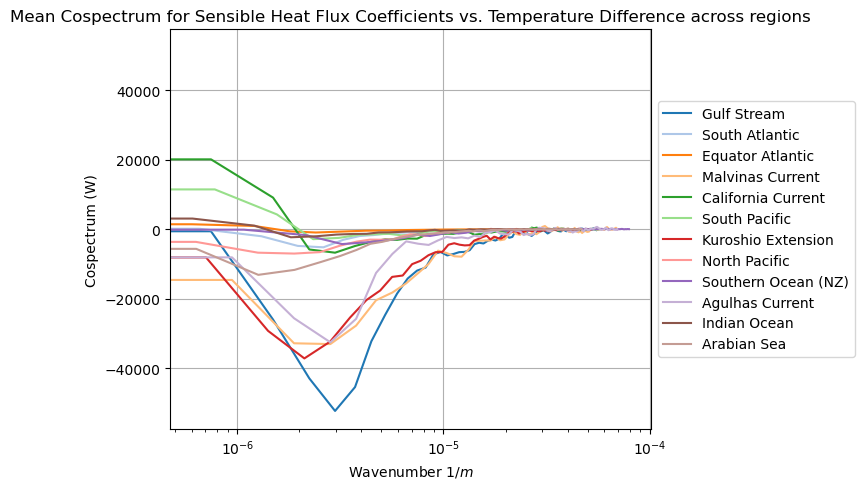

In [124]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    eps = 1e-2
    T_diff = cropped_boxes_HR[i].t_ref - cropped_boxes_HR[i].surface_temp
    C = cropped_boxes_qh[i] / (T_diff + eps)

    T_diff_t = T_diff.chunk({"xt_ocean": -1})
    C_t = C.chunk({"xt_ocean": -1})

    # degree to m conversion
    lat_mean = T_diff_t.yt_ocean.mean().item() 
    T_diff_t = T_diff_t.assign_coords(xt_ocean = T_diff_t.xt_ocean * 111000 * np.cos(np.deg2rad(lat_mean)))
    C_t = C_t.assign_coords(xt_ocean = C_t.xt_ocean * 111000 * np.cos(np.deg2rad(lat_mean)))

    cross_specs = xrft.cross_spectrum(T_diff_t, C_t, dim='xt_ocean', window=True, detrend="linear", density=False)
    cross_spec_mean = cross_specs.mean(['yt_ocean', 'time']).compute()

    plt.plot(
        cross_spec_mean["freq_xt_ocean"],
        cross_spec_mean.real * cross_spec_mean["freq_xt_ocean"],
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel(r"Wavenumber $1/m$")
plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.ylabel("Cospectrum (W)")
plt.title("Mean Cospectrum for Sensible Heat Flux Coefficients vs. Temperature Difference across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

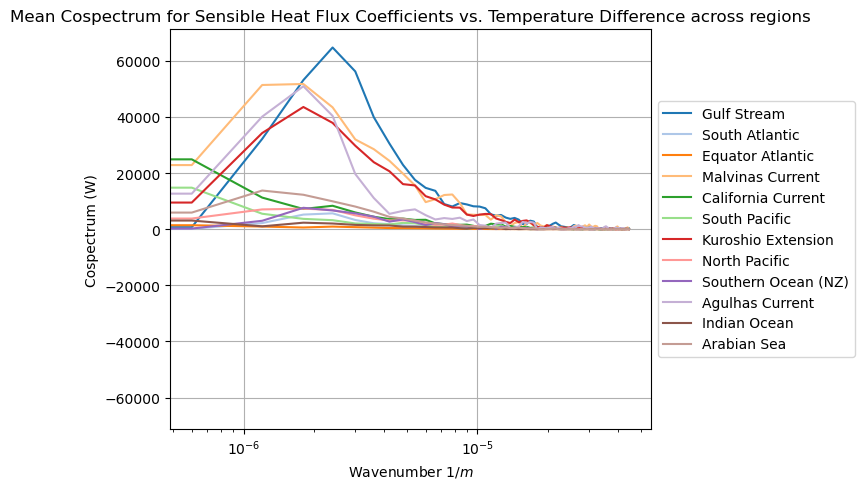

In [33]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    eps = 1e-2
    T_diff = cropped_boxes_HR[i].t_ref - cropped_boxes_HR[i].surface_temp
    C = cropped_boxes_qh[i] / (T_diff + eps)

    T_diff_t = T_diff.chunk({"xt_ocean": -1})
    C_t = C.chunk({"xt_ocean": -1})

    # degree to m conversion
    T_diff_t = T_diff_t.assign_coords(xt_ocean=T_diff_t.xt_ocean*111000)
    C_t = C_t.assign_coords(xt_ocean=C_t.xt_ocean*111000)

    cross_specs = xrft.cross_spectrum(T_diff_t, C_t, dim='xt_ocean', window=True, detrend="linear", density=False)
    cross_spec_mean = cross_specs.mean(['yt_ocean', 'time']).compute()

    plt.plot(
        cross_spec_mean["freq_xt_ocean"],
        np.abs(cross_spec_mean.real) * cross_spec_mean["freq_xt_ocean"],
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel(r"Wavenumber $1/m$")
plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.ylabel("Cospectrum (W)")
plt.title("Mean Cospectrum for Sensible Heat Flux Coefficients vs. Temperature Difference across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

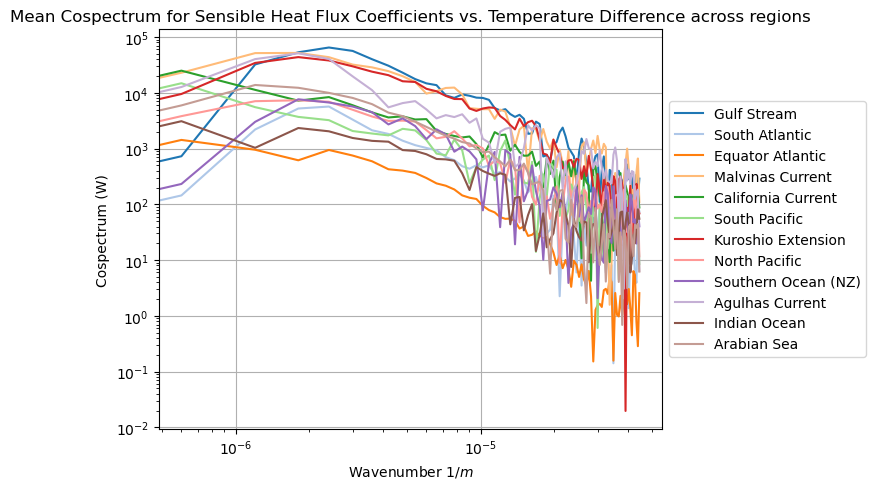

In [34]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):

    eps = 1e-2
    T_diff = cropped_boxes_HR[i].t_ref - cropped_boxes_HR[i].surface_temp
    C = cropped_boxes_qh[i] / (T_diff + eps)

    T_diff_t = T_diff.chunk({"xt_ocean": -1})
    C_t = C.chunk({"xt_ocean": -1})

    # degree to m conversion
    T_diff_t = T_diff_t.assign_coords(xt_ocean=T_diff_t.xt_ocean*111000)
    C_t = C_t.assign_coords(xt_ocean=C_t.xt_ocean*111000)

    cross_specs = xrft.cross_spectrum(T_diff_t, C_t, dim='xt_ocean', window=True, detrend="linear", density=False)
    cross_spec_mean = cross_specs.mean(['yt_ocean', 'time']).compute()

    plt.plot(
        cross_spec_mean["freq_xt_ocean"],
        np.abs(cross_spec_mean.real) * cross_spec_mean["freq_xt_ocean"],
        label=box_names[i],
        color=colors[i]
    )

plt.xlabel(r"Wavenumber $1/m$")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.ylabel("Cospectrum (W)")
plt.title("Mean Cospectrum for Sensible Heat Flux Coefficients vs. Temperature Difference across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

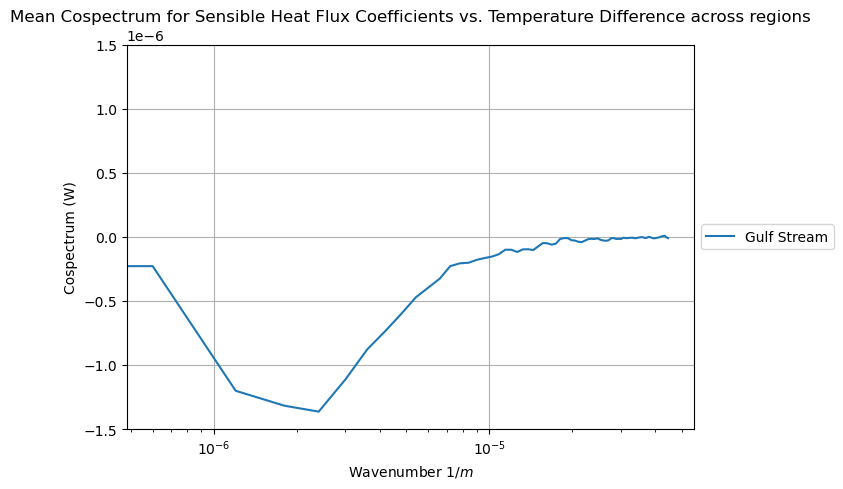

In [20]:
plt.figure(figsize=(8,5))
colors = plt.get_cmap('tab20').colors

i = 0

eps = 1e-2
T_diff = ds_HR.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-55, -40)).t_ref - ds_HR.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-55, -40)).surface_temp
C = ds_QLQH.qh.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-55, -40)) / (T_diff + eps) # prevent division by 0

#T_diff = cropped_boxes_HR[i].surface_temp - cropped_boxes_HR[i].t_ref
#C = cropped_boxes_qh[i] / (T_diff + eps)

T_diff_t = T_diff.chunk({"xt_ocean": -1})
C_t = C.chunk({"xt_ocean": -1})

# degree to m conversion
T_diff_t = T_diff_t.assign_coords(xt_ocean=T_diff_t.xt_ocean*111000)
C_t = C_t.assign_coords(xt_ocean=C_t.xt_ocean*111000)

cross_specs = xrft.cross_spectrum(T_diff_t, C_t, dim='xt_ocean', window=True, detrend="linear", density=False)

cross_spec_mean = cross_specs.mean(['yt_ocean', 'time']).compute()
cs_max = np.abs(cross_spec_mean[1:].real).max()

plt.plot(
    cross_spec_mean["freq_xt_ocean"],
    cross_spec_mean.real * cross_spec_mean["freq_xt_ocean"] / cs_max,
    label=box_names[i],
    color=colors[i]
)

plt.xlabel(r"Wavenumber $1/m$")
plt.xscale('log')
#plt.yscale('log')
plt.ylabel("Cospectrum (W)")
plt.grid()
plt.title("Mean Cospectrum for Sensible Heat Flux Coefficients vs. Temperature Difference across regions")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()

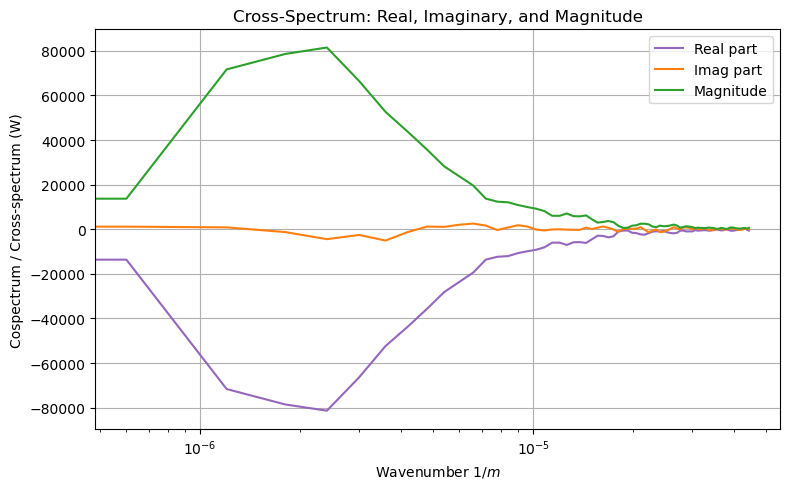

In [44]:
colors = plt.get_cmap('tab20').colors
i = 0

# Compute T_diff and C once
eps = 1e-2
T_diff = ds_HR.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-55, -40)).t_ref - \
         ds_HR.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-55, -40)).surface_temp
C = ds_QLQH.qh.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-55, -40)) / (T_diff + eps)

# Convert to time-chunked and degree-to-m
T_diff_t = T_diff.chunk({"xt_ocean": -1}).assign_coords(xt_ocean=T_diff.xt_ocean*111000)
C_t = C.chunk({"xt_ocean": -1}).assign_coords(xt_ocean=C.xt_ocean*111000)

# Compute cross-spectrum and mean over y and time
cross_specs = xrft.cross_spectrum(T_diff_t, C_t, dim='xt_ocean', window=True, detrend="linear", density=False)
cross_spec_mean = cross_specs.mean(['yt_ocean', 'time']).compute()

# Plot all three on the same axes
plt.figure(figsize=(8,5))

plt.plot(cross_spec_mean["freq_xt_ocean"], 
         cross_spec_mean.real * cross_spec_mean["freq_xt_ocean"], 
         label="Real part", color='tab:purple')
plt.plot(cross_spec_mean["freq_xt_ocean"], 
         cross_spec_mean.imag * cross_spec_mean["freq_xt_ocean"], 
         label="Imag part", color='tab:orange')
plt.plot(cross_spec_mean["freq_xt_ocean"], 
         np.abs(cross_spec_mean) * cross_spec_mean["freq_xt_ocean"], 
         label="Magnitude", color='tab:green')

plt.xscale('log')
plt.xlabel("Wavenumber $1/m$")
plt.ylabel("Cospectrum / Cross-spectrum (W)")
plt.grid(True)
plt.title("Cross-Spectrum: Real, Imaginary, and Magnitude")
plt.legend()
plt.tight_layout()
plt.show()

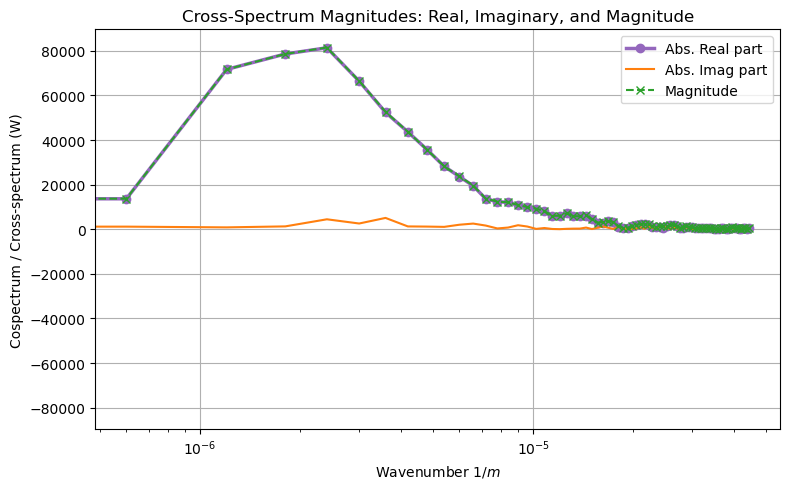

In [43]:
colors = plt.get_cmap('tab20').colors
i = 0

# Compute T_diff and C once
eps = 1e-2
T_diff = ds_HR.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-55, -40)).t_ref - \
         ds_HR.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-55, -40)).surface_temp
C = ds_QLQH.qh.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-55, -40)) / (T_diff + eps)

# Convert to time-chunked and degree-to-m
T_diff_t = T_diff.chunk({"xt_ocean": -1}).assign_coords(xt_ocean=T_diff.xt_ocean*111000)
C_t = C.chunk({"xt_ocean": -1}).assign_coords(xt_ocean=C.xt_ocean*111000)

# Compute cross-spectrum and mean over y and time
cross_specs = xrft.cross_spectrum(T_diff_t, C_t, dim='xt_ocean', window=True, detrend="linear", density=False)
cross_spec_mean = cross_specs.mean(['yt_ocean', 'time']).compute()

# Plot all three on the same axes
plt.figure(figsize=(8,5))

plt.plot(cross_spec_mean["freq_xt_ocean"], 
         np.abs(cross_spec_mean.real) * cross_spec_mean["freq_xt_ocean"], 
         label="Abs. Real part", color='tab:purple', linewidth=2.5, marker='o')
plt.plot(cross_spec_mean["freq_xt_ocean"], 
         np.abs(cross_spec_mean.imag) * cross_spec_mean["freq_xt_ocean"], 
         label="Abs. Imag part", color='tab:orange')
plt.plot(cross_spec_mean["freq_xt_ocean"], 
         np.abs(cross_spec_mean) * cross_spec_mean["freq_xt_ocean"], 
         label="Magnitude", color='tab:green', linestyle='--', linewidth=1.5, marker='x')

plt.xscale('log')
plt.xlabel("Wavenumber $1/m$")
plt.ylabel("Cospectrum / Cross-spectrum (W)")
plt.grid(True)
plt.title("Cross-Spectrum Magnitudes: Real, Imaginary, and Magnitude")
plt.legend()
plt.tight_layout()
plt.show()

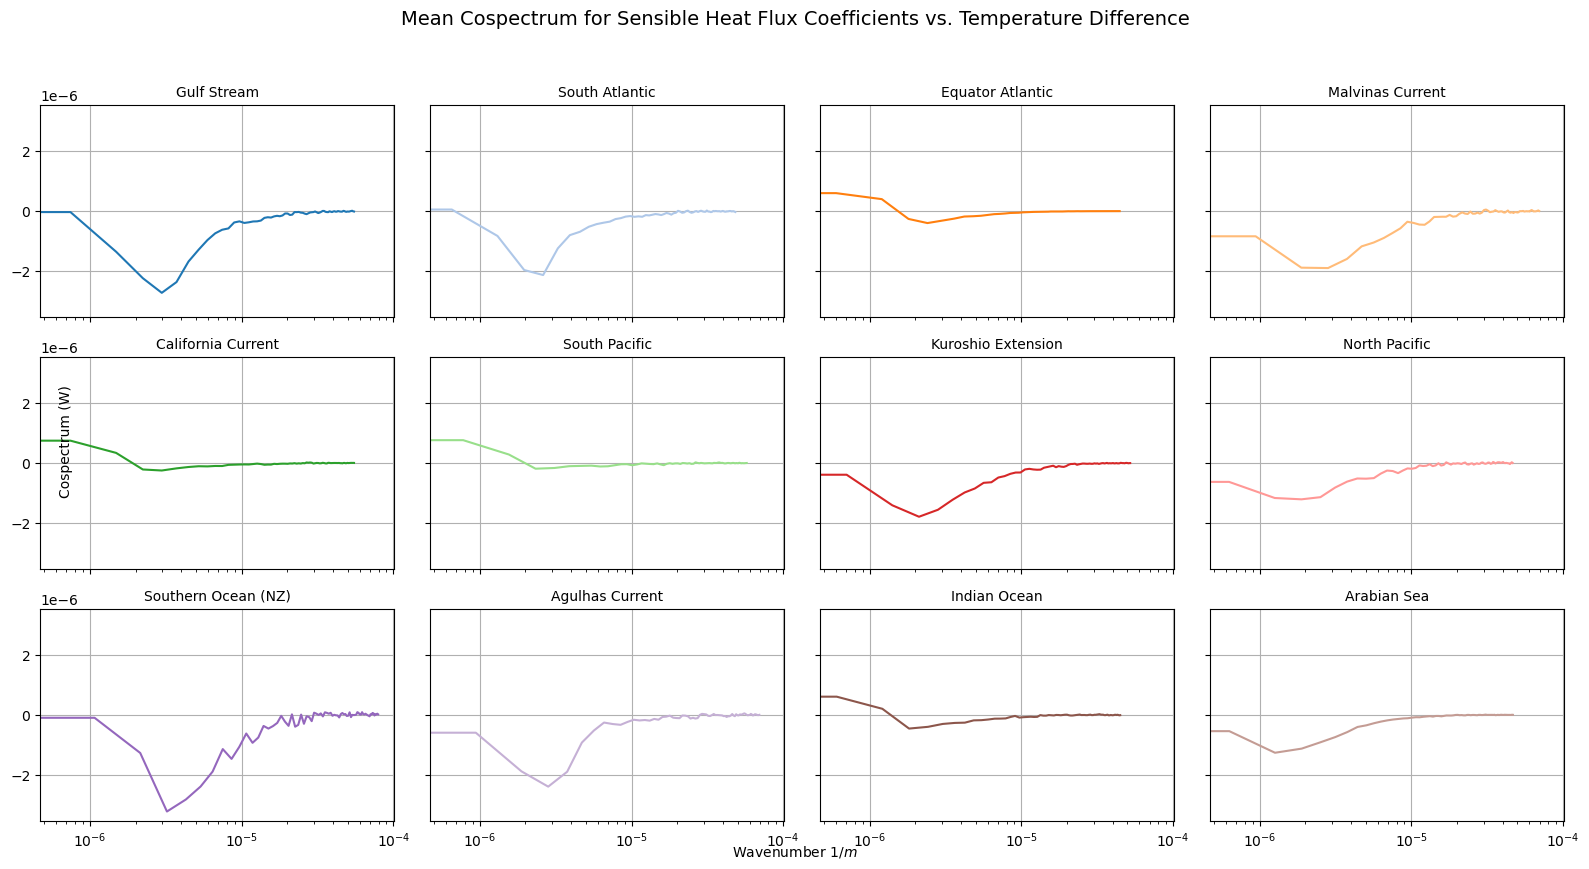

In [23]:
fig, axes = plt.subplots(3, 4, figsize=(16, 9), sharex=True, sharey=True)
axes = axes.flatten()  # flatten into 1D array for easy indexing
colors = plt.get_cmap('tab20').colors

for i, box in enumerate(cropped_boxes_HR):
    eps = 1e-2
    T_diff = cropped_boxes_HR[i].t_ref - cropped_boxes_HR[i].surface_temp
    C = cropped_boxes_qh[i] / (T_diff + eps)

    T_diff_t = T_diff.chunk({"xt_ocean": -1})
    C_t = C.chunk({"xt_ocean": -1})

    # degree to m conversion
    lat_mean = T_diff_t.yt_ocean.mean().item() 
    T_diff_t = T_diff_t.assign_coords(xt_ocean = T_diff_t.xt_ocean * 111000 * np.cos(np.deg2rad(lat_mean)))
    C_t = C_t.assign_coords(xt_ocean = C_t.xt_ocean * 111000 * np.cos(np.deg2rad(lat_mean)))

    cross_specs = xrft.cross_spectrum(
        T_diff_t, C_t, dim="xt_ocean",
        window=True, detrend="linear", density=False
    )
    cross_spec_mean = cross_specs.mean(["yt_ocean", "time"]).compute()
    cospec_max = np.abs(cross_spec_mean[1:].real).max()

    ax = axes[i]
    ax.plot(
        cross_spec_mean["freq_xt_ocean"],
        cross_spec_mean.real * cross_spec_mean["freq_xt_ocean"] / cospec_max,
        color=colors[i]
    )
    ax.set_xscale("log")
    ax.grid(True)
    ax.set_title(box_names[i], fontsize=10)

# Add global labels
fig.text(0.5, 0.04, r"Wavenumber $1/m$", ha='center')
fig.text(0.04, 0.5, "Cospectrum (W)", va='center', rotation='vertical')
fig.suptitle("Mean Cospectrum for Sensible Heat Flux Coefficients vs. Temperature Difference", fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [24]:
eps = 1e-2
T_diff = cropped_boxes_HR[0].t_ref - cropped_boxes_HR[0].surface_temp
UV_rel = np.sqrt(cropped_boxes_HR[0].u_relative ** 2 + cropped_boxes_HR[0].v_relative ** 2)
C = cropped_boxes_qh[0] / (T_diff * UV_rel + eps)
C_delU = cropped_boxes_qh[0] / (T_diff + eps)

T_diff_t = T_diff.chunk({"xt_ocean": -1})
C_t = C.chunk({"xt_ocean": -1})
C_delU_t = C_delU.chunk({"xt_ocean": -1})
UVrel_t = UV_rel.chunk({"xt_ocean": -1})

# degree to m conversion
lat_mean = T_diff_t.yt_ocean.mean().item() 
T_diff_t = T_diff_t.assign_coords(xt_ocean = T_diff_t.xt_ocean * 111000 * np.cos(np.deg2rad(lat_mean)))
UVrel_t = UVrel_t.assign_coords(xt_ocean = UVrel_t.xt_ocean * 111000 * np.cos(np.deg2rad(lat_mean)))
C_delU_t = C_delU_t.assign_coords(xt_ocean = C_delU_t.xt_ocean * 111000 * np.cos(np.deg2rad(lat_mean)))
C_t = C_t.assign_coords(xt_ocean = C_t.xt_ocean * 111000 * np.cos(np.deg2rad(lat_mean)))

cross_specs = xrft.cross_spectrum(T_diff_t, C_delU_t, dim='xt_ocean', window=True, detrend="linear", density=False)
cross_spec_mean = cross_specs.mean(["yt_ocean"]).compute()

In [29]:
Cmean = C.mean().values
Cmean_delU = Cmean * UV_rel
Cmean_delU_t = Cmean_delU.chunk({"xt_ocean": -1})
lat_mean = T_diff_t.yt_ocean.mean().item() 
Cmean_delU_t = Cmean_delU_t.assign_coords(xt_ocean = Cmean_delU_t.xt_ocean * 111000 * np.cos(np.deg2rad(lat_mean)))

cross_specs_Cmean = xrft.cross_spectrum(T_diff_t, Cmean_delU_t, dim='xt_ocean', window=True, detrend="linear", density=False)
cross_spec_mean_Cmean = cross_specs_Cmean.mean(["yt_ocean"]).compute()

In [37]:
def plot_fun(idt): 
    fig, axes = plt.subplots(ncols=4, figsize=(20, 5), constrained_layout=True)

    # Cospectrum
    axes[0].plot(
        cross_spec_mean[idt]["freq_xt_ocean"],
        cross_spec_mean[idt].real * cross_spec_mean[idt]["freq_xt_ocean"],
        color="tab:blue",
        label="Varying C"
    )
    axes[0].set_title('Cospectrum')
    axes[0].set_xscale('log')
    axes[0].set_ylim(-200000, 200000)
    axes[0].grid(True)
    axes[0].set_xlabel('Wavenumber (1/m)')
    axes[0].set_ylabel('Cospectrum (W)')

    axes[0].plot(
        cross_spec_mean_Cmean[idt]["freq_xt_ocean"],
        cross_spec_mean_Cmean[idt].real * cross_spec_mean_Cmean[idt]["freq_xt_ocean"],
        color="tab:orange",
        label="Mean C"
    )
    axes[0].set_title('Cospectrum')
    axes[0].set_xscale('log')
    axes[0].set_ylim(-200000, 200000)
    axes[0].grid(True)
    axes[0].legend()
    axes[0].set_xlabel('Wavenumber (1/m)')
    axes[0].set_ylabel('Cospectrum (W)')
    
    # T_diff_t map
    T_diff_t[idt].plot.pcolormesh(ax=axes[1], robust=True, cmap='coolwarm', vmax=10, vmin=-10)
    axes[1].set_title('ΔT')
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')

    # UV_rel_t map
    UVrel_t[idt].plot.pcolormesh(ax=axes[2], robust=True, vmin=4, vmax=20)
    axes[2].set_title('ΔU')
    axes[2].set_xlabel('')
    axes[2].set_ylabel('')

    # C_t map
    C_t[idt].plot.pcolormesh(ax=axes[3], robust=True, cmap='magma', vmin=1, vmax=2.5)
    axes[3].set_title('C')
    axes[3].set_xlabel('')
    axes[3].set_ylabel('')

    fig.suptitle("SHF Cospectrum Variables through Time")

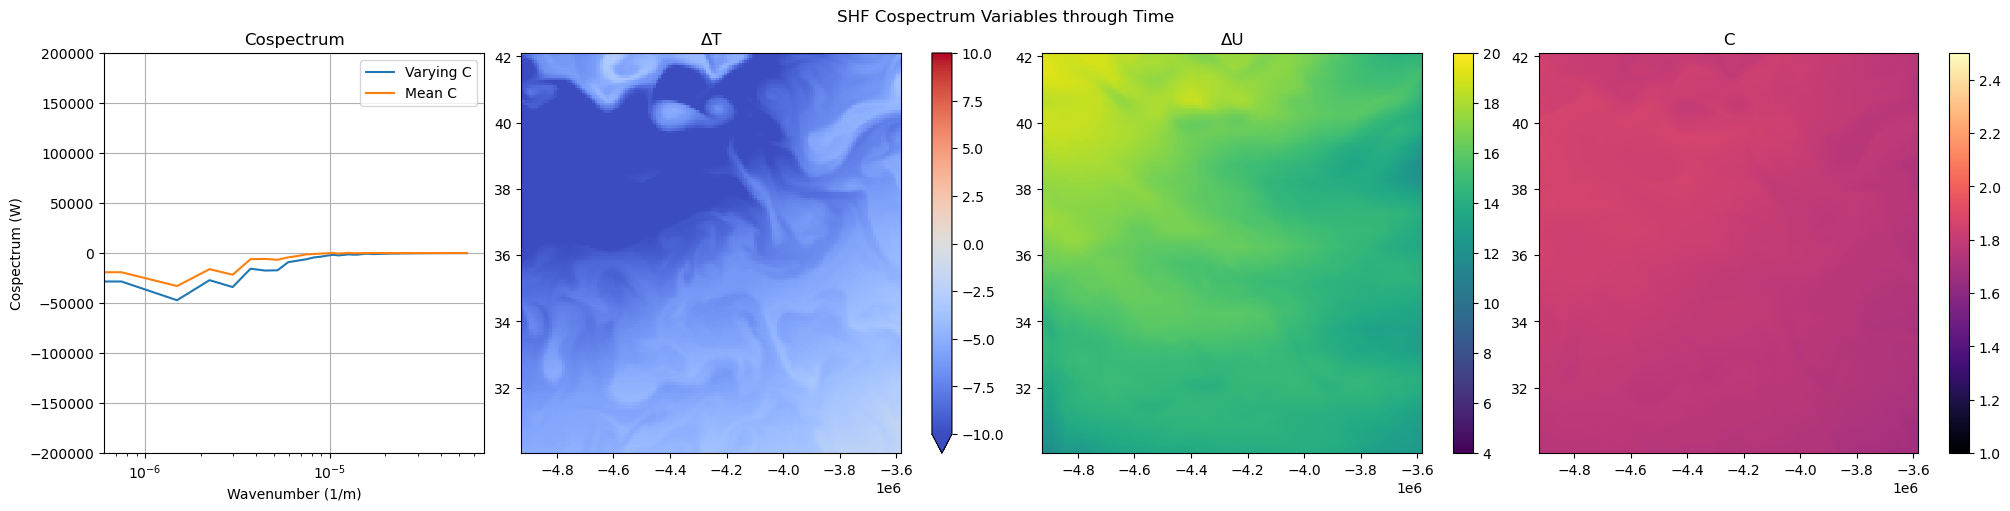

In [38]:
plot_fun(10)

In [39]:
# Specific for animation
# Can be put in a separate script
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import cmocean

# Thanks to Pavel for this function :) 
def create_animation(fun, idx, filename='filename.gif', dpi=200, FPS=18, loop=0):
    '''
    See https://pythonprogramming.altervista.org/png-to-gif/
    fun(i) - a function creating one snapshot, has only one input:
        - number of frame i
    idx - range of frames, i in idx
    FPS - frames per second
    filename - animation name
    dpi - set 300 or so to increase quality
    loop - number of repeats of the gif
    '''
    frames = []
    for i in idx:
        fun(i)
        plt.savefig('.frame.png', dpi=dpi, bbox_inches='tight')
        plt.close()
        frames.append(Image.open('.frame.png').convert('RGB'))
        print(f'Frame {i} is created', end='\r')
    os.system('rm .frame.png')
    # How long to persist one frame in milliseconds to have a desired FPS
    duration = 1000 / FPS
    print(f'Animation at FPS={FPS} will last for {len(idx)/FPS} seconds')
    frames[0].save(
        filename, format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=duration,
        loop=loop)

In [40]:
create_animation(plot_fun, range(0, 30), 'SHF_cospectra_GS_Cmean.gif', dpi=100, FPS=2)

Animation at FPS=2 will last for 15.0 seconds
